In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.optimize as opt
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import random
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

In [6]:
path = os.getcwd()
data = loadmat(path+'\ex5data1.mat')#its a dictionary
print data.keys()
print 'Data:\n',data['X'].shape,'\n','Target:\n',data['y'].shape,'\n'
print 'Data Val:\n',data['Xval'].shape,'\n','Target Val:\n',data['yval'].shape,'\n'
print 'Data Test:\n',data['Xtest'].shape,'\n','Target Test:\n',data['ytest'].shape,'\n'


['ytest', 'yval', '__header__', '__globals__', 'Xtest', 'Xval', 'y', 'X', '__version__']
Data:
(12L, 1L) 
Target:
(12L, 1L) 

Data Val:
(21L, 1L) 
Target Val:
(21L, 1L) 

Data Test:
(21L, 1L) 
Target Test:
(21L, 1L) 



In [7]:
X= data['X']
Y= data['y']
X_Val = data['Xval']
Y_Val = data['yval']
X_Test = data['Xtest']
Y_Test = data['ytest']

In [8]:
X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)
X_Val = np.insert(X_Val, 0, values=np.ones(X_Val.shape[0]), axis=1)
X_Val = np.insert(X_Test, 0, values=np.ones(X_Test.shape[0]), axis=1)

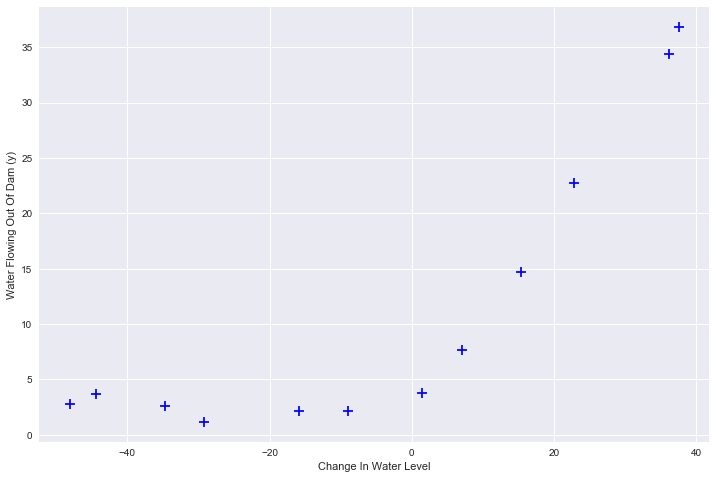

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(X[:,1],Y,s=100, c='b',marker = '+')
plt.xlabel('Change In Water Level')
plt.ylabel('Water Flowing Out Of Dam (y)')

## Linear Regression Cost
<img src='Cost.png'>

In [263]:
def computeCost(weights,X,Y,penalty):
    cost = np.sum(np.power((np.dot(X,weights)-Y),2))/(2*len(X))
    reg = (penalty*np.sum(np.power(weights[1:],2)))/(2*len(X))
    cost_reg = cost + reg
    return cost_reg

In [360]:
weights_one = np.ones((X.shape[1],1))
computeCost(weights_one,X,Y,penalty=0)

303.95152555359761

## Gradient Update
<img src ='grad.png'>

In [64]:
def gradientRegVec(weight, X, Y, penalty):
    Y = Y.ravel()
    error = (np.dot(X,weight) - Y)
    effect = np.dot(X.transpose(),error)#np.dot(error, X[:,i]) 
    grad = (effect / len(X)) + ((penalty / len(X)) * weight)
    grad[0] = effect[0] / len(X)
    return grad

def gradientDescentRegVec(weight,X,Y,alpha,iters,penalty):
    cost = np.zeros(iters)
    for j in range(iters):
        error = (np.dot(X,weight) - Y) #compute error and keep it same for each weight update for simultaneous update
        effect = np.dot(X.transpose(),error)
        dW = (effect/len(X)) + ((penalty / len(X)) * weight)
        dW[0] = (effect[0]/len(X)) 
        weight = weight - (alpha*dW)
        cost[j] = computeCost(weight,X,Y,penalty)
    return weight,cost

In [22]:
gradientRegVec(weights_one,X,Y,penalty=0)

array([[ -15.30301567],
       [ 598.16741084]])

In [358]:
#Train Linear Regression
weights_initial = np.array([[20],[24]])
penalty = 0
result = opt.minimize(computeCost,x0= weights_initial, method='L-BFGS-B',jac=gradientRegVec, args=(X, Y, penalty))

In [359]:
print result.x
print result.fun

[ 13.08790353   0.36777917]
1604.4000739


In [243]:
def predict(X,weight):
    return np.dot(X,weight)

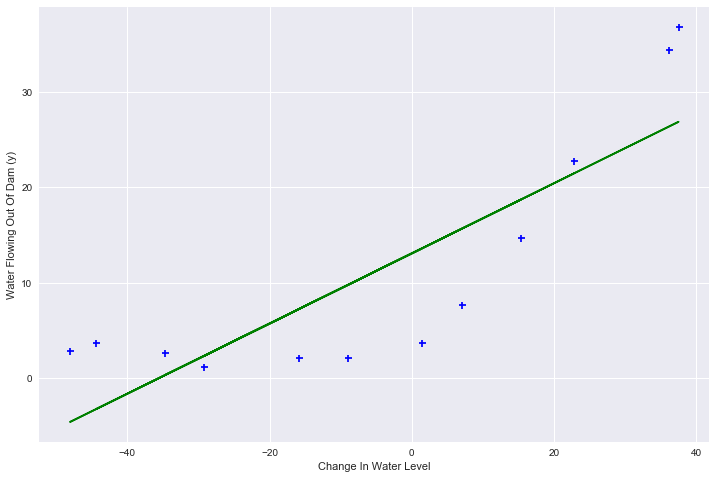

In [376]:
plt.figure(figsize=(12,8))
plt.scatter(X[:,1], Y,c='b',marker='+')
plt.plot(X[:,1],predict(X,result.x),'g-')
plt.xlabel('Change In Water Level')
plt.ylabel('Water Flowing Out Of Dam (y)')

# Learning Curves

In [353]:
def learningCurve(weights,X,Y,X_Val,Y_Val,penalty,skl = False):
    error_train, error_val = np.zeros((len(X),1)), np.zeros((len(X),1))
    for i in range(1,(len(X)+1)):
        X_sub = X[:i,:]
        Y_sub = Y[:i]
        coeff = np.array(len(weights))#get coeff on full data
        if skl == False:
            result_sub = opt.minimize(computeCost,x0= weights, method='L-BFGS-B',jac=gradientRegVec,\
                                      args=(X_sub, Y_sub, penalty))
            coeff = result_sub['x']
        else:
            fit_reg = Ridge(alpha=penalty,fit_intercept=False)
            fit_reg.fit(X_sub, Y_sub)
            coeff = fit_reg.coef_.ravel()

        error_train[i-1] = computeCost(coeff,X_sub,Y_sub,0)
        error_val[i-1] = computeCost(coeff,X_Val,Y_Val,0)
        
    return error_train,error_val,coeff

In [354]:
weights_initial = np.array([[15.0],[10.0]])
penalty = 0
error_train,error_val,coeff = learningCurve(weights_initial,X,Y,X_Val,Y_Val,penalty)

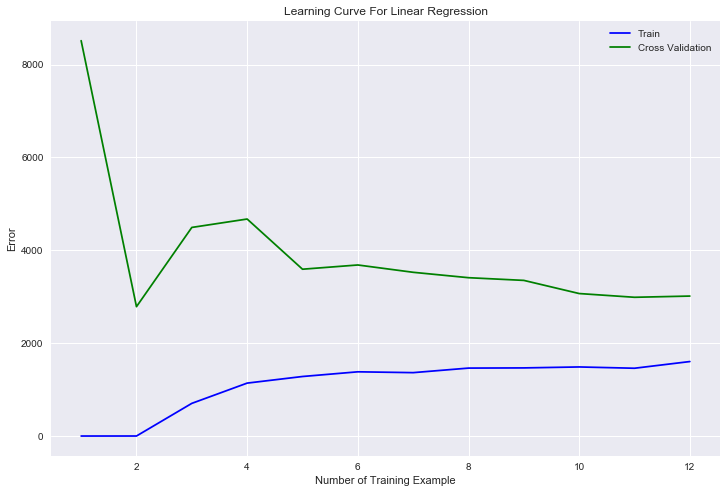

In [355]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(1,len(X)+1),error_train,c='b',label ='Train')
plt.plot(np.arange(1,len(X)+1),error_val,c='g',label ='Cross Validation')
plt.title('Learning Curve For Linear Regression')
plt.xlabel('Number of Training Example')
plt.ylabel('Error')
plt.legend()

# Polynomial Regression and Bias v.s Variance

In [252]:
###MAKE FUNCTION LATER
#Get Polynomial Features
poly = PolynomialFeatures(degree=8)
X_8 = poly.fit_transform(X[:,1].reshape(-1,1))

#Normalize Features
X_8_means = np.mean(X_8,axis=0)
X_8[:,1:] = X_8[:,1:] - X_8_means[1:]
X_8_stds = np.std(X_8,axis=0,ddof=1)
X_8[:,1:] = X_8[:,1:] / X_8_stds[1:]

#Get Polynomial Features
X_8_Val = poly.fit_transform(X_Val[:,1].reshape(-1,1))

#Normalize Features
X_8_Val_means = np.mean(X_8_Val,axis=0)
X_8_Val[:,1:] = X_8_Val[:,1:] - X_8_Val_means[1:]
X_8_Val_stds = np.std(X_8_Val,axis=0,ddof=1)
X_8_Val[:,1:] = X_8_Val[:,1:] / X_8_Val_stds[1:]

In [341]:
weights_initial = np.zeros(9)
penalty = 0
error_train_0,error_val_0,coeff_0 = learningCurve(weights_initial,X_8,Y,X_8_Val,Y_Val,penalty,skl=True)

In [334]:
fake_x = np.linspace(-50,40)
fake_x = fake_x.reshape(fake_x.shape[0],1)

#Get Polynomial Features
fake_x = np.insert(fake_x, 0, values=np.ones(fake_x.shape[0]), axis=1)
fake_x_poly = poly.fit_transform(fake_x[:,1].reshape(-1,1))

#Normalize Features
fake_x_poly_means = np.mean(fake_x_poly,axis=0)
fake_x_poly[:,1:] = fake_x_poly[:,1:] - fake_x_poly_means[1:]
fake_x_poly_stds = np.std(fake_x_poly,axis=0,ddof=1)
fake_x_poly[:,1:] = fake_x_poly[:,1:] / fake_x_poly_stds[1:]

In [356]:
def getPerf(penalty,skl = True):
    weights_initial = np.zeros(9)
    error_train_p,error_val_p,coeff_p = learningCurve(weights_initial,X_8,Y,X_8_Val,Y_Val,penalty,skl)

    plt.figure(figsize=(12,8))
    plt.scatter(X[:,1], Y,c='b',marker='+')
    plt.plot(np.linspace(-50,40),predict(fake_x_poly,coeff_p),'g-')
    plt.title('Polynomial Fit with (lambda={})'.format(penalty))
    plt.xlabel('Change In Water Level')
    plt.ylabel('Water Flowing Out Of Dam (y)')
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(np.arange(1,len(X)+1),error_train_p,c='b',label ='Train')
    plt.plot(np.arange(1,len(X)+1),error_val_p,c='g',label ='Cross Validation')
    plt.title('Learning Curve For Polynomial Regression with (lambda={})'.format(penalty))
    plt.xlabel('Number of Training Example')
    plt.ylabel('Error')
    plt.legend()

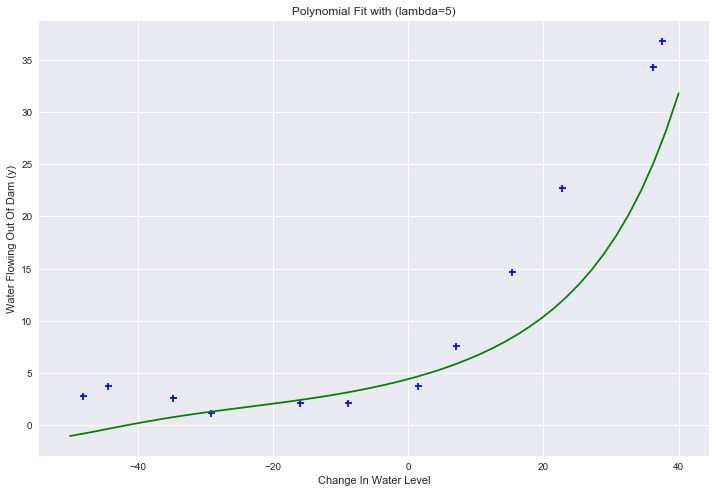

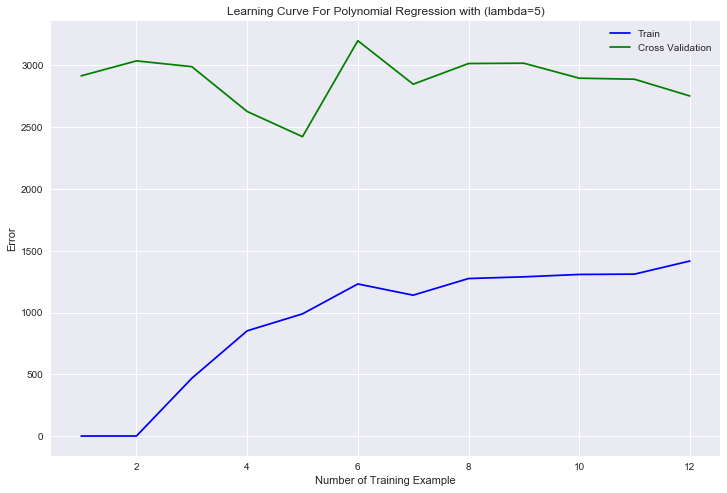

In [377]:
getPerf(penalty=5,skl=False)